## Multiclass Classification Project

Learning Goals
    
    -> How To Read Different Size Images From A Directory
    -> How To Implement One-vs-One Scheme for Multiclass Classification
    -> How To Use SVM for Image Classification

### Dataset Preparation

In [3]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
from keras.preprocessing import image
import random
from sklearn import svm

In [4]:
p = Path("Dataset/")

dirs = p.glob("*")

labels_dict = {"cat":0, "dog":1, "horse":2, "human":3}
image_data = []
labels = []

for folder_dir in dirs:
    
    label = str(folder_dir).split("\\")[-1][:-1]
    
    for img_path in folder_dir.glob("*.jpg"):
        img = image.load_img(img_path, target_size=(32, 32))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(labels_dict[label])

In [5]:
print(len(image_data))
print(len(labels))

808
808


In [6]:
print(set(labels))

{0, 1, 2, 3}


### Convert This Data Into Numpy Array

In [7]:
image_data = np.array(image_data, dtype='float32')/255.0
labels = np.array(labels)

print(image_data.shape)
print(labels.shape)

(808, 32, 32, 3)
(808,)


### Randomly Shuffle Our Data !

In [8]:
# Zip The Data
combined = list(zip(image_data, labels))

# Shuffle
random.shuffle(combined)

# Unzip
image_data[:], labels[:] = zip(*combined)

### Visualise This Data !

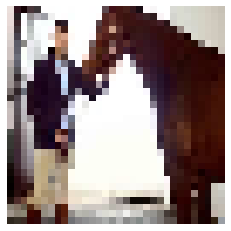

In [9]:
def drawImg(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return

drawImg(image_data[0])

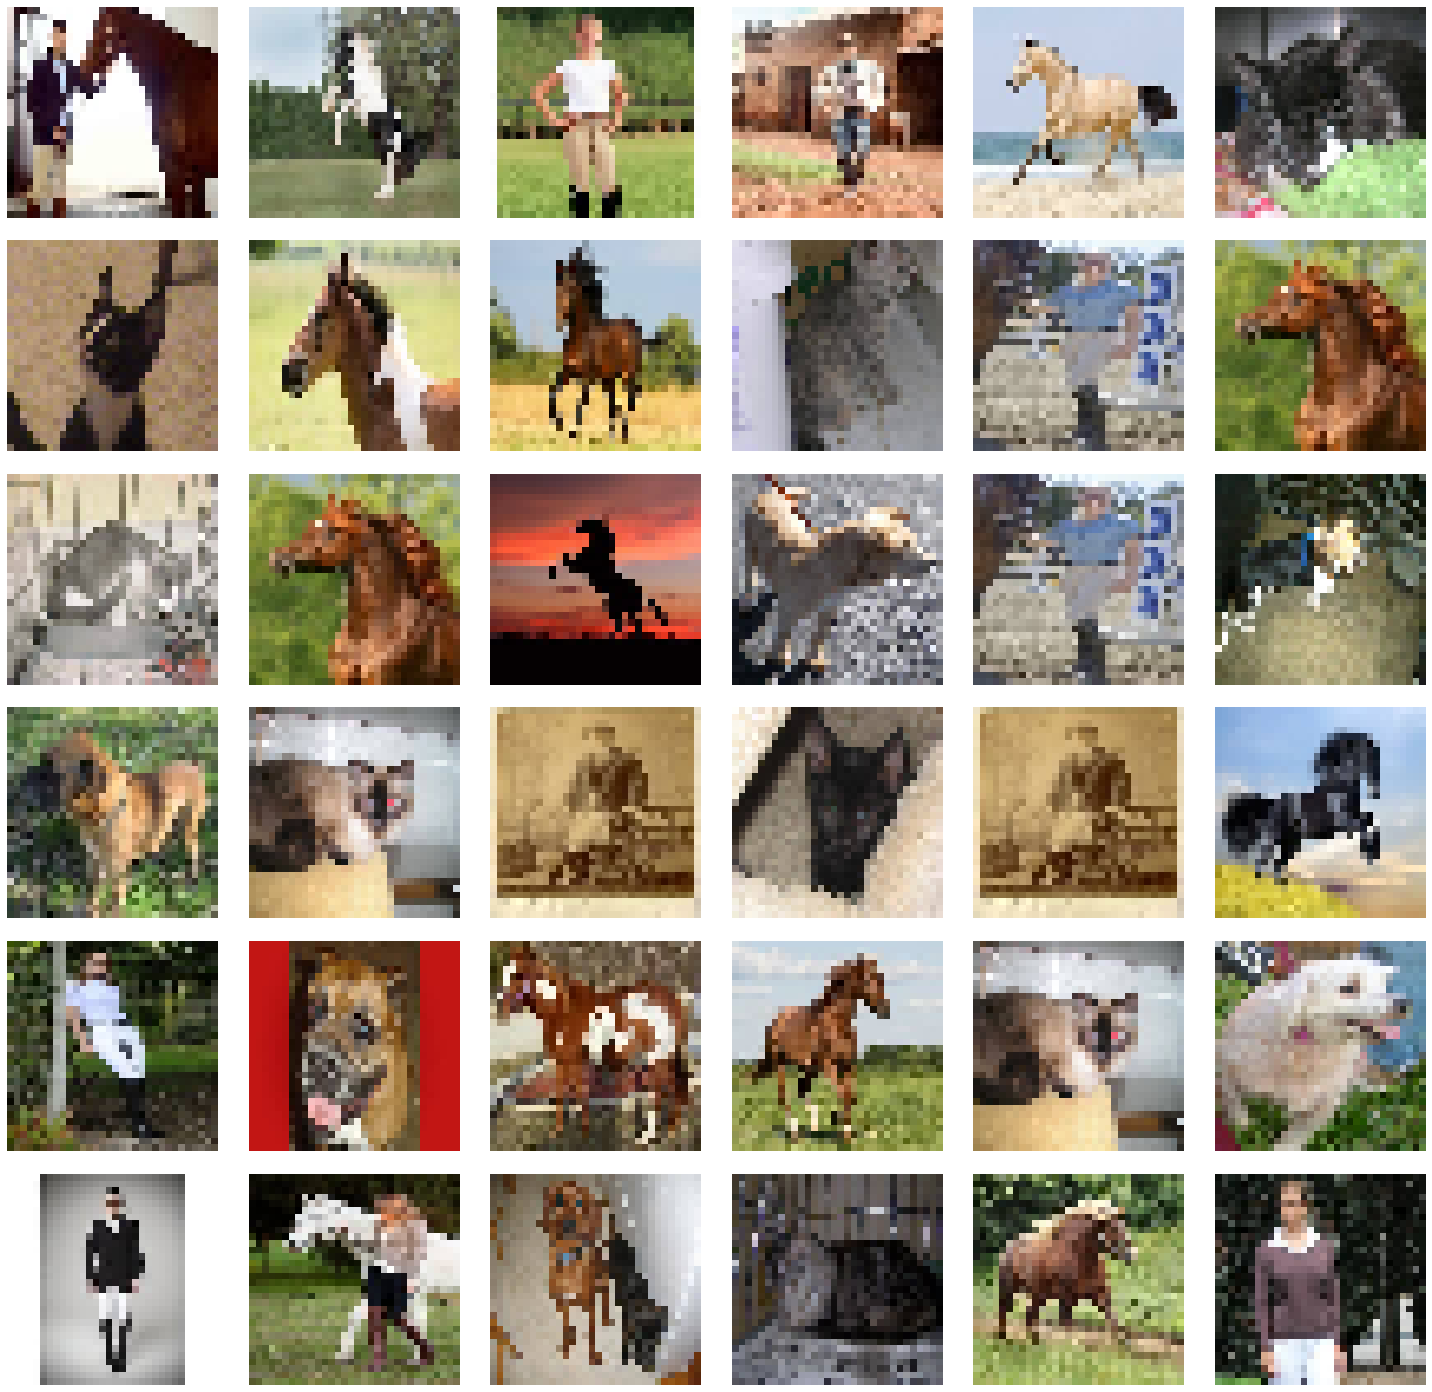

In [10]:
# Plotting A Few Images
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, len(image_data[:36])+1):
    ax = fig.add_subplot(6, 6, i)
    plt.imshow(image_data[i-1])
    plt.tight_layout()
    plt.axis("off")
plt.show()

## SVM Classifier

In [11]:
class SVM:
    
    def __init__(self, C=1.0):
        
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self, W, b, X, Y):
        
        loss = 0.0
        loss += 0.5 * np.dot(W, W.T)
        
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i] * (np.dot(W, X[i].T) + b) # Scalar
            loss += self.C * max(0, (1-ti))
            
        return loss[0][0]
    
    def fit(self, X, Y, batch_size=100, learning_rate=0.001, maxItr=300):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        # Init The Model Parameters
        W = np.zeros((1, no_of_features))
        bias = 0
        
        # Training
        # Weight and Bias Update Rule
        losses = []
        
        for i in range(maxItr):
            # Training Loop
            l = self.hingeLoss(W, bias, X, Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            # Batch Gradient Descent With Random Sampling
            for batch_start in range(0, no_of_samples, batch_size):
                
                # Assume Zero Gradient For The Batch
                gradw = 0
                gradb = 0
                
                # Iterate Over All Examples in the Mini Batch
                for j in range(batch_start, batch_start+batch_size):
                    if (j < no_of_samples):
                        i = ids[j]
                    
                        ti = Y[i] * (np.dot(W, X[i].T) + bias)
                    
                        if (ti > 1):
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c * Y[i] * X[i]
                            gradb += c * Y[i]
                            
                # Gradient For The Batch Is Ready
                W = W - n*W + n*gradw
                bias = bias + n*gradb
            
        self.W = W
        self.b = bias
        return W, bias, losses

## We Need To Convert Data For One vs One Classification !!

In [12]:
M = image_data.shape[0]
image_data = image_data.reshape(M, -1)
print(image_data.shape)
print(labels.shape)

(808, 3072)
(808,)


In [13]:
CLASSES = len(np.unique(labels))
def classWiseData(X, Y):
    """ Makes a Class Wise Dictionary From Entire Data"""
    data = {}
    for i in range(CLASSES):
        data[i] = []
    for i in range(X.shape[0]):
        data[Y[i]].append(X[i])
    for k in data.keys():
        data[k] = np.array(data[k])
    return data

In [14]:
data = classWiseData(image_data, labels)

In [15]:
print(data[0].shape)
print(data[1].shape)
print(data[2].shape)
print(data[3].shape)

(202, 3072)
(202, 3072)
(202, 3072)
(202, 3072)


### Create Pairs

In [16]:
def getDataPairForSVM(d1, d2):
    """ Combines Data of Two Classes Into a Single Matrix"""
    l1, l2 = d1.shape[0], d2.shape[0]
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples, features))
    data_labels = np.zeros((samples,))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    # As Labels Are For SVM
    data_labels[:l1] = -1
    data_labels[l1:] = +1
    
    return data_pair, data_labels

## Training NC2 SVMs !!

In [17]:
mySVM = SVM()

In [18]:
def trainSVMs(data):
    """ This Functions Train All The NC2 SVMs and Store Their
    Weights and Biases Into A Dictionary and Also Plots The
    Loss Curve For All SVMs"""
    svm_classifiers = {}
    for i in range(CLASSES):
        svm_classifiers[i] = {}
        for j in range(i+1, CLASSES):
            xpair, ypair = getDataPairForSVM(data[i], data[j])
            wts, b, loss = mySVM.fit(xpair, ypair, learning_rate=0.00001, maxItr=1000)
            plt.plot(loss, label=("Classes " + str(i) + " & " + str(j)))
            svm_classifiers[i][j] = (wts, b)

    plt.title("Losses For NC2 Different SVM Classifiers")
    plt.legend()
    plt.show()
    
    return svm_classifiers

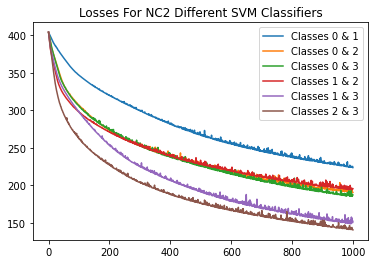

In [19]:
svm_classifiers = trainSVMs(data)

In [20]:
# Parameters for Cats and Dogs
cats_dogs = svm_classifiers[0][1]
print(cats_dogs[0].shape)
print(cats_dogs[1])

# Parameters for Cats and Humans
cats_humans = svm_classifiers[0][3]
print(cats_humans[0].shape)
print(cats_humans[1])

(1, 3072)
0.012669999999999975
(1, 3072)
-0.0004100000000000011


In [21]:
def binaryPredict(x, w, b):
    z = np.dot(x,w.T) + b
    if z >= 0:
        return 1
    else:
        return -1

In [22]:
def predict(x):
    count = np.zeros((CLASSES,))
    
    for i in range(CLASSES):
        for j in range(i+1, CLASSES):
            w, b = svm_classifiers[i][j]
            # Take a Majority Prediction
            z = binaryPredict(x, w, b)
            
            if(z==1):
                count[j] += 1
            else:
                count[i] += 1
    
    final_prediction = np.argmax(count)
    
    return final_prediction

In [23]:
def accuracy(x, y):
    count = 0
    
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        if(prediction==y[i]):
            count+=1
    return count/x.shape[0]

In [24]:
print("Accuracy : ", np.round((100*accuracy(image_data, labels)), 2), "%")

Accuracy :  58.04 %


### Using Scikit Learn

In [25]:
svm_classifier = svm.SVC(kernel='linear', C=1.0)

In [26]:
svm_classifier.fit(image_data, labels)
print("Accuracy : ", np.round((100 * svm_classifier.score(image_data, labels)), 2), "%")

Accuracy :  63.0 %
